In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from numba import jit
import time
import gc
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
import xgboost as xgb
import lightgbm
import pickle
from sklearn.preprocessing import StandardScaler
import math

kfold_seed = 0
models_seed = 0
np_seed = 0

# Compute Gini metric functions

In [2]:
# from CPMP's kernel https://www.kaggle.com/cpmpml/extremely-fast-gini-computation
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini
    
    
# Funcitons from olivier's kernel
# https://www.kaggle.com/ogrellier/xgb-classifier-upsampling-lb-0-283

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = -eval_gini(labels, preds)
    return [('gini', gini_score)]

# Load predictions

In [3]:
# Train meta and test meta which contain the predictions
train_meta = pd.read_csv('train_meta_stratified_5.csv')
test_meta = pd.read_csv('test_meta_stratified_5.csv')

# Load LRT
df_ltr_valid = pd.read_csv('ltr_validation.csv')
df_ltr_valid.drop(['Unnamed: 0', 'target'], axis=1, inplace=True)
df_ltr_test = pd.read_csv('ltr_test.csv')
df_ltr_test.drop('Unnamed: 0', axis=1, inplace=True)
train_meta = pd.merge(train_meta, df_ltr_valid, on='id')
test_meta['ltr'] = df_ltr_test['target']
# optional with ltr: scale (try if use the predictions for stacking)
#train_meta['ltr'] = (train_meta['ltr']-train_meta['ltr'].min())/(train_meta['ltr'].max()-train_meta['ltr'].min())
#test_meta['ltr'] = (test_meta['ltr']-test_meta['ltr'].min())/(test_meta['ltr'].max()-test_meta['ltr'].min())


# Load from some public kernels

# NN EntityEmbed: https://www.kaggle.com/aquatic/entity-embedding-neural-net
df_NN_EntityEmbed_valid = pd.read_csv('public_kernels/NN_EntityEmbed_10fold-val_preds.csv')
df_NN_EntityEmbed_test = pd.read_csv('public_kernels/NN_EntityEmbed_10fold-sub.csv')
train_meta['NN_EntityEmbed'] = df_NN_EntityEmbed_valid['0']
test_meta['NN_EntityEmbed'] = df_NN_EntityEmbed_test['target']

# Old school NN: https://www.kaggle.com/snowdog/old-school-nnet
df_oldschoolNN_valid_1 = pd.read_csv('public_kernels/old-school-nnet_valid1.csv')
df_oldschoolNN_valid_2 = pd.read_csv('public_kernels/old-school-nnet_valid2.csv')
df_oldschoolNN_valid_3 = pd.read_csv('public_kernels/old-school-nnet_valid3.csv')
df_oldschoolNN_valid_4 = pd.read_csv('public_kernels/old-school-nnet_valid4.csv')
df_oldschoolNN_valid_5 = pd.read_csv('public_kernels/old-school-nnet_valid5.csv')
df_oldschoolNN_valid = pd.concat([df_oldschoolNN_valid_1, df_oldschoolNN_valid_2, df_oldschoolNN_valid_3, df_oldschoolNN_valid_4, df_oldschoolNN_valid_5])
df_oldschoolNN_test = pd.read_csv('public_kernels/old-school-nnet_sub_nnet_folds.csv')
train_meta = pd.merge(train_meta, df_oldschoolNN_valid, on='id')
test_meta = pd.merge(test_meta, df_oldschoolNN_test, on='id')
train_meta.rename(columns={'target_y': 'oldschoolNN', 'target_x': 'target'}, inplace=True)
test_meta.rename(columns={'target': 'oldschoolNN'}, inplace=True)

#RGF: https://www.kaggle.com/tunguz/rgf-target-encoding-0-282-on-lb/output
df_RGF_valid = pd.read_csv('public_kernels/rgf_valid.csv')
df_RGF_test = pd.read_csv('public_kernels/rgf_submit.csv')
train_meta = pd.merge(train_meta, df_RGF_valid, on='id')
test_meta = pd.merge(test_meta, df_RGF_test, on='id')
train_meta.rename(columns={'target_y': 'RGF', 'target_x': 'target'}, inplace=True)
test_meta.rename(columns={'target': 'RGF'}, inplace=True)

#RGF2: https://www.kaggle.com/lscoelho/rgf-with-23-nonlinear-features/
df_RGF_valid = pd.read_csv('public_kernels/rgf_valid_2.csv')
df_RGF_test = pd.read_csv('public_kernels/rgf_submit_2.csv')
train_meta = pd.merge(train_meta, df_RGF_valid, on='id')
test_meta = pd.merge(test_meta, df_RGF_test, on='id')
train_meta.rename(columns={'target_y': 'RGF2', 'target_x': 'target'}, inplace=True)
test_meta.rename(columns={'target': 'RGF2'}, inplace=True)

del df_NN_EntityEmbed_valid, df_NN_EntityEmbed_test
del df_oldschoolNN_valid_1, df_oldschoolNN_valid_2, df_oldschoolNN_valid_3, df_oldschoolNN_valid_4, df_oldschoolNN_valid_5
del df_oldschoolNN_valid, df_oldschoolNN_test

In [4]:
train_meta4 = pd.read_csv('train_meta_stratified_4.csv')
test_meta4 = pd.read_csv('test_meta_stratified_4.csv')
train_meta6 = pd.read_csv('train_meta_stratified_6.csv')
test_meta6 = pd.read_csv('test_meta_stratified_6.csv')
train_meta7 = pd.read_csv('train_meta_stratified_7.csv')
test_meta7 = pd.read_csv('test_meta_stratified_7.csv')
for c in train_meta4.drop(['id', 'target'], axis=1).columns:
    if c in train_meta:
        print('c already in train_meta (4)')
    train_meta[c] = train_meta4[c]
    test_meta[c] = test_meta4[c]
for c in train_meta6.drop(['id', 'target'], axis=1).columns:
    if c in train_meta:
        print('c already in train_meta (6)')
    train_meta[c] = train_meta6[c]
    test_meta[c] = test_meta6[c]
for c in train_meta7.drop(['id', 'target'], axis=1).columns:
    if c in train_meta:
        print('c already in train_meta (7)')
    train_meta[c] = train_meta7[c]
    test_meta[c] = test_meta7[c]

In [5]:
train_meta.head()

,id,target,xgb1_FS1,xgb2_FS1,lgb1_FS3,lgb2_FS3,catboost1_FS3,catboost2_FS3,catboost3_FS3,RForest1_FS6,...,lgb2_FS15,catboost1_FS15,catboost2_FS15,catboost3_FS15,RForest1_FS16,RForest2_FS14,RForest3_FS14,LR1_FS14,xgb3_FS17,lgb3_FS17
0,7,0,0.053054,0.036508,0.035964,0.035512,0.038288,0.037519,0.038638,0.043202,...,0.037126,0.037185,0.035144,0.033398,0.044162,0.042106,0.039044,0.500689,0.061662,0.044947
1,9,0,0.052980,0.034036,0.035894,0.030180,0.033580,0.032459,0.030049,0.034117,...,0.031206,0.034490,0.033355,0.029478,0.036368,0.036774,0.038263,0.505967,0.043654,0.032765
2,13,0,0.031771,0.021110,0.016545,0.017060,0.017867,0.020013,0.017954,0.020899,...,0.018541,0.020107,0.019473,0.020568,0.021736,0.020704,0.021562,0.357723,0.035742,0.017009
3,16,0,0.021677,0.014408,0.014192,0.015797,0.014040,0.016284,0.015753,0.016483,...,0.015126,0.014184,0.015889,0.016059,0.017064,0.016857,0.017025,0.265479,0.023759,0.013855
4,17,0,0.055609,0.032151,0.030553,0.031474,0.029792,0.033922,0.034713,0.042312,...,0.031915,0.029748,0.034625,0.033698,0.046960,0.045260,0.043385,0.513518,0.051076,0.031679


In [6]:
test_meta.head()

,id,xgb1_FS1,xgb2_FS1,lgb1_FS3,lgb2_FS3,catboost1_FS3,catboost2_FS3,catboost3_FS3,RForest1_FS6,RForest2_FS2,...,lgb2_FS15,catboost1_FS15,catboost2_FS15,catboost3_FS15,RForest1_FS16,RForest2_FS14,RForest3_FS14,LR1_FS14,xgb3_FS17,lgb3_FS17
0,0,0.038662,0.023925,0.025420,0.025559,0.023955,0.023623,0.024433,0.023645,0.021849,...,0.024054,0.022922,0.022951,0.022608,0.021952,0.022075,0.022044,0.360636,0.039113,0.024466
1,1,0.033991,0.023012,0.023353,0.022532,0.023760,0.023367,0.022031,0.023199,0.022508,...,0.020517,0.023378,0.023594,0.022280,0.023459,0.022257,0.021710,0.375787,0.034408,0.023075
2,2,0.033939,0.023016,0.021546,0.022635,0.022074,0.024145,0.023330,0.025624,0.024866,...,0.024837,0.024563,0.025476,0.024796,0.026096,0.024261,0.023465,0.382935,0.039141,0.024523
3,3,0.021338,0.013830,0.016135,0.014097,0.014309,0.015621,0.014096,0.015728,0.015181,...,0.014148,0.014181,0.015887,0.014109,0.016062,0.015860,0.014243,0.323100,0.022921,0.015596
4,4,0.059547,0.036870,0.039816,0.038227,0.038177,0.037614,0.037237,0.039492,0.041344,...,0.041309,0.037101,0.036475,0.037241,0.041871,0.040809,0.040664,0.508814,0.060227,0.039366


In [7]:
pred_columns = train_meta.drop(['id', 'target'], axis=1).columns.values
print(pred_columns)

['xgb1_FS1' 'xgb2_FS1' 'lgb1_FS3' 'lgb2_FS3' 'catboost1_FS3'
 'catboost2_FS3' 'catboost3_FS3' 'RForest1_FS6' 'RForest2_FS2'
 'RForest3_FS2' 'LR1_FS2' 'xgb3_FS7' 'lgb3_FS7' 'ltr' 'NN_EntityEmbed'
 'oldschoolNN' 'RGF' 'RGF2' 'xgb1' 'xgb2' 'lgb1' 'lgb2' 'catboost1'
 'catboost2' 'catboost3' 'RForest1' 'RForest2' 'RForest3' 'ExtraTree1'
 'LR1' 'xgb3' 'lgb3' 'xgb1_FS8' 'xgb2_FS8' 'lgb1_FS10' 'lgb2_FS10'
 'catboost1_FS10' 'catboost2_FS10' 'catboost3_FS10' 'RForest1_FS11'
 'RForest2_FS9' 'RForest3_FS9' 'LR1_FS9' 'xgb3_FS12' 'lgb3_FS12'
 'xgb1_FS13' 'xgb2_FS13' 'lgb1_FS15' 'lgb2_FS15' 'catboost1_FS15'
 'catboost2_FS15' 'catboost3_FS15' 'RForest1_FS16' 'RForest2_FS14'
 'RForest3_FS14' 'LR1_FS14' 'xgb3_FS17' 'lgb3_FS17']


# Show correlation between the different model predictions

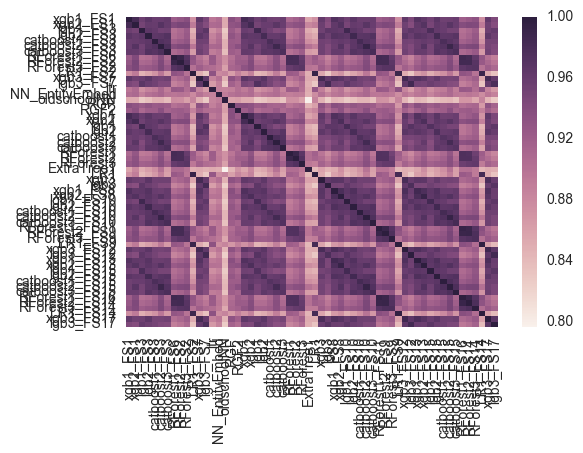

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
corr = train_meta[pred_columns].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

# CV Validation for each model individually

In [9]:
for m in pred_columns:
    print(m + ':' + str(eval_gini(train_meta.target, train_meta[m])))

xgb1_FS1:0.287950400202
xgb2_FS1:0.283881437257
lgb1_FS3:0.287070290858
lgb2_FS3:0.28703155883
catboost1_FS3:0.286721366645
catboost2_FS3:0.282411218983
catboost3_FS3:0.286345207361
RForest1_FS6:0.276564045724
RForest2_FS2:0.278013491447
RForest3_FS2:0.277738732114
LR1_FS2:0.269995706215
xgb3_FS7:0.287842153708
lgb3_FS7:0.28585938733
ltr:0.273901117927
NN_EntityEmbed:0.276816137135
oldschoolNN:0.279029945728
RGF:0.283633569799
RGF2:0.276489441199
xgb1:0.288046013899
xgb2:0.284421805069
lgb1:0.28742875413
lgb2:0.287559384506
catboost1:0.28591085648
catboost2:0.280604361918
catboost3:0.285791647191
RForest1:0.274808812288
RForest2:0.276497521477
RForest3:0.277853811327
ExtraTree1:0.254441026793
LR1:0.269969589946
xgb3:0.28542750874
lgb3:0.284953125548
xgb1_FS8:0.2879920387
xgb2_FS8:0.285282595016
lgb1_FS10:0.286896886789
lgb2_FS10:0.287497800179
catboost1_FS10:0.286377927927
catboost2_FS10:0.282642162016
catboost3_FS10:0.286157651112
RForest1_FS11:0.277588066695
RForest2_FS9:0.2787740960

# Simple Mean ranks

In [72]:
models_use = ['xgb1_FS1', 'xgb2_FS1', 'lgb1_FS3', 'lgb2_FS3', 'catboost1_FS3',
 'catboost2_FS3', 'catboost3_FS3', 'RForest1_FS6', 'RForest2_FS2',
 'RForest3_FS2', 'LR1_FS2', 'xgb3_FS7', 'lgb3_FS7', 'ltr', 'NN_EntityEmbed',
 'oldschoolNN', 'RGF', 'RGF2', 'xgb1', 'xgb2', 'lgb1', 'lgb2', 'catboost1',
 'catboost2', 'catboost3', 'RForest1', 'RForest2', 'RForest3', 'ExtraTree1',
 'LR1', 'xgb3', 'lgb3', 'xgb1_FS8', 'xgb2_FS8', 'lgb1_FS10', 'lgb2_FS10',
 'catboost1_FS10', 'catboost2_FS10', 'catboost3_FS10', 'RForest1_FS11',
 'RForest2_FS9', 'RForest3_FS9', 'LR1_FS9', 'xgb3_FS12', 'lgb3_FS12',
 'xgb1_FS13', 'xgb2_FS13', 'lgb1_FS15', 'lgb2_FS15', 'catboost1_FS15',
 'catboost2_FS15', 'catboost3_FS15', 'RForest1_FS16', 'RForest2_FS14',
 'RForest3_FS14', 'LR1_FS14', 'xgb3_FS17', 'lgb3_FS17'] # 

               
mean_ranks = (train_meta[models_use].rank() / train_meta.shape[0]).mean(axis=1)
print((eval_gini(train_meta.target, mean_ranks)))

0.292210356975


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
corr = train_meta[models_use].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [25]:
models_use = ['xgb1_FS1', 'xgb2_FS1', 'lgb1_FS3', 'lgb2_FS3', 'catboost1_FS3', 'catboost2_FS3', 'catboost3_FS3', 
              'RForest1_FS6', 'RForest2_FS2', 'RForest3_FS2', 'LR1_FS2', 'xgb3_FS7', 'lgb3_FS7',
             'NN_EntityEmbed', 'oldschoolNN', 'ltr', 'RGF']

models_use = ['xgb1_FS1', 'lgb1_FS3', 'lgb2_FS3',   
              'xgb3_FS7', 'lgb3_FS7',
             'NN_EntityEmbed', 'oldschoolNN', 'RGF'] 0.291926245051



               
mean_ranks = (train_meta[models_use].rank() / train_meta.shape[0]).mean(axis=1)
print((eval_gini(train_meta.target, mean_ranks)))

0.291926245051


In [58]:
models_use = ['xgb1_FS1',  'lgb1_FS3',  
 'xgb3_FS7', 'NN_EntityEmbed',
 'oldschoolNN', 'RGF', 'xgb1', 'lgb1'] #0.292262007287
               
mean_ranks_test = (test_meta[models_use].rank() / test_meta.shape[0]).mean(axis=1)

sub = pd.DataFrame()
sub['id'] = test_meta.id
sub['target'] = mean_ranks_test.values
sub.to_csv('mean_ranking_2.csv', index=False)

# Weighted mean ranks

In [159]:
models_use = ['xgb1_rank', 'xgb2_FS8_rank', 'xgb3_FS7_rank', 'lgb1_rank', 'lgb2_FS3_rank', 
              'lgb3_FS7_rank', 'catboost1_FS3_rank', 'catboost2_FS10_rank', 'catboost3_FS3_rank', 'ltr_rank',  
              'RForest1_FS11_rank', 'LR1_FS9_rank', 'NN_EntityEmbed_rank', 'oldschoolNN_rank', 'RGF_rank']  # 
weights = [0.17, 0.03, 0.12, 0.12, 0.12, #0.48
          0.07, 0.08, 0.02, 0.07, 0.02, # 0.39
           0.02, 0.02, 0.05, 0.04, 0.05] #0.14

print(np.sum(weights))
y_val = train_meta.target * 0
for i in range(len(models_use)):
    mean_ranks = train_meta[models_use[i]].rank() / train_meta.shape[0]
    y_val += mean_ranks * weights[i]
               

print((eval_gini(train_meta.target, y_val)))

1.0
0.29114401851


In [137]:
0.45 + 0.37 + 0.14  #0.29114401851

0.9600000000000001

In [161]:
models_use = ['xgb1_rank', 'xgb2_FS8_rank', 'xgb3_FS7_rank', 'lgb1_rank', 'lgb2_FS3_rank', 
              'lgb3_FS7_rank', 'catboost1_FS3_rank', 'catboost2_FS10_rank', 'catboost3_FS3_rank', 'ltr_rank',  
              'RForest1_FS11_rank', 'LR1_FS9_rank', 'NN_EntityEmbed_rank', 'oldschoolNN_rank', 'RGF_rank']  # 
weights = [0.17, 0.03, 0.12, 0.12, 0.12, #0.48
          0.07, 0.08, 0.02, 0.07, 0.02, # 0.39
           0.02, 0.02, 0.05, 0.04, 0.05] #0.14

y_test = test_meta.xgb1_FS1 * 0
for i in range(len(models_use)):
    mean_ranks = test_meta[models_use[i]].rank() / test_meta.shape[0]
    y_test += mean_ranks * weights[i]
               
sub = pd.DataFrame()
sub['id'] = test_meta.id
sub['target'] = y_test.values
sub.to_csv('mean_weighted_ranking_3.csv', index=False)

# Stacking mean ranks

In [111]:
models_use = ['xgb1_FS1', 'xgb2_FS1', 'lgb1_FS3', 'lgb2_FS3', 'catboost1_FS3',
 'catboost2_FS3', 'catboost3_FS3', 'RForest1_FS6', 'RForest2_FS2',
 'RForest3_FS2', 'LR1_FS2', 'xgb3_FS7', 'lgb3_FS7', 'ltr', 'NN_EntityEmbed',
 'oldschoolNN', 'RGF', 'RGF2', 'xgb1', 'xgb2', 'lgb1', 'lgb2', 'catboost1',
 'catboost2', 'catboost3', 'RForest1', 'RForest2', 'RForest3', 'ExtraTree1',
 'LR1', 'xgb3', 'lgb3', 'xgb1_FS8', 'xgb2_FS8', 'lgb1_FS10', 'lgb2_FS10',
 'catboost1_FS10', 'catboost2_FS10', 'catboost3_FS10', 'RForest1_FS11',
 'RForest2_FS9', 'RForest3_FS9', 'LR1_FS9', 'xgb3_FS12', 'lgb3_FS12',
 'xgb1_FS13', 'xgb2_FS13', 'lgb1_FS15', 'lgb2_FS15', 'catboost1_FS15',
 'catboost2_FS15', 'catboost3_FS15', 'RForest1_FS16', 'RForest2_FS14',
 'RForest3_FS14', 'LR1_FS14', 'xgb3_FS17', 'lgb3_FS17'] 
# Compute ranks for each model
rank_columns = []
for m in models_use:
    train_meta[m + '_rank'] = train_meta[m].rank() / train_meta.shape[0]
    test_meta[m + '_rank'] = test_meta[m].rank() / test_meta.shape[0]
    rank_columns.append(m + '_rank')

In [135]:
rank_columns = ['xgb1_rank', 'xgb2_FS8_rank', 'xgb3_FS7_rank', 'lgb1_rank', 'lgb2_FS3_rank', 'lgb3_FS7_rank', 
                'catboost1_FS3_rank', 'catboost2_FS10_rank', 'ltr_rank', 
             'catboost3_FS3_rank', 'RForest1_FS11_rank', 'LR1_FS9_rank', 'NN_EntityEmbed_rank', 'oldschoolNN_rank', 'RGF_rank'] 
# 0.291757213626
# K-fold CV for hyperparemeter tuning of the stacked model (LR)
y = train_meta.target
y_valid_pred = 0*y
extra_features = []
stacking_model = LogisticRegression(C=10, fit_intercept=True)
val_gini_stack = []
K = 5
kf = StratifiedKFold(n_splits = K, random_state = kfold_seed, shuffle = True)
for i, (train_index, test_index) in enumerate(kf.split(train_meta,y)):
    # Create data for this fold
    y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
    X_train, X_valid = train_meta.loc[train_index, rank_columns].copy(), train_meta.loc[test_index, rank_columns].copy()
    stacking_model.fit(X_train, y_train)
    print(stacking_model.coef_)
    print(stacking_model.intercept_ )
    pred = stacking_model.predict_proba(X_valid)[:,1]
    val_gini_stack.append(eval_gini(y_valid, pred))
    print("Val Gini = ", str(val_gini_stack[-1]))
    y_valid_pred.iloc[test_index] = pred 
print(np.mean(val_gini_stack))
print("Val Gini = ", str(eval_gini(y, y_valid_pred)))

[[ 0.46877493 -0.23674108  0.3559442   0.46280227 -0.1749343   0.03165188
   0.22041768 -0.24968461  0.03698883  0.14865138  0.04118529 -0.01999599
   0.1950061   0.3393211   0.28166502]]
[-4.35359286]
Val Gini =  0.297363915872
[[ 0.46160415 -0.25321224  0.17718645  0.46033567 -0.15252081  0.15206334
   0.16711046 -0.30400831  0.01888493  0.12584246  0.19714405 -0.02874146
   0.27654394  0.34603106  0.27673864]]
[-4.36505016]
Val Gini =  0.290411745007
[[ 0.38661103 -0.1384025   0.30256297  0.50413111 -0.21012861  0.12989703
   0.10257351 -0.5123231   0.03565096  0.3723466   0.18957064 -0.06092043
   0.18773261  0.38352487  0.24289155]]
[-4.36274715]
Val Gini =  0.289921426184
[[ 0.58251832 -0.25286854  0.34502613  0.50707428 -0.07444138 -0.08675706
   0.28082593 -0.40231544  0.06878081  0.11405456  0.05512637 -0.05256297
   0.13463603  0.32256765  0.3573406 ]]
[-4.35319089]
Val Gini =  0.29451740749
[[ 0.3864972  -0.16774125  0.3246142   0.43389183  0.03314367  0.10009128
   0.175652

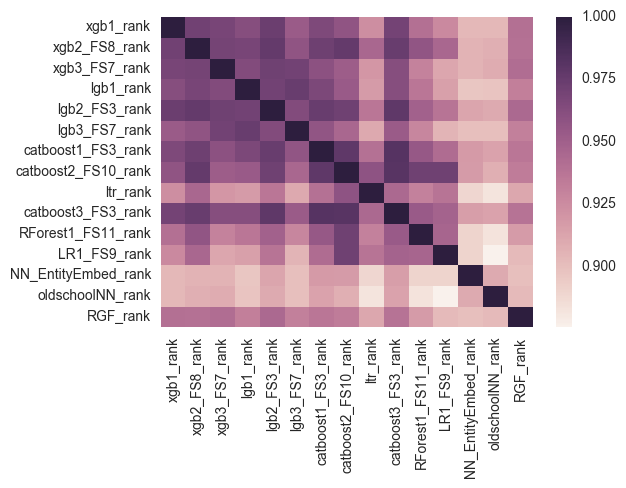

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
corr = train_meta[rank_columns].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [136]:
# With LR
# Fit a new model, S (i.e the stacking model) to train_meta, using predictions of other models as features. 
# Optionally, include other features from the original training dataset or engineered features
stacking_model = LogisticRegression(C=10)
stacking_model.fit(train_meta[rank_columns], y)
# Use the stacked model S to make final predictions on test_meta
res = stacking_model.predict_proba(test_meta[rank_columns])[:,1]

sub = pd.DataFrame()
sub['id'] = test_meta.id
sub['target'] = res
sub.to_csv('stacked_2_lr_stratified_3.csv', index=False)
print(stacking_model.coef_)
print(stacking_model.intercept_ )

[[ 0.45669092 -0.21049068  0.29895172  0.4735616  -0.11564236  0.06695543
   0.18984196 -0.36109766  0.0166589   0.15361091  0.13633303 -0.03863028
   0.20528131  0.35222447  0.28732315]]
[-4.35997987]


# Stacking predictions

In [17]:
models_use = ['xgb1_FS1', 'xgb2_FS1', 'lgb1_FS3', 'lgb2_FS3', 'catboost1_FS3', 'catboost3_FS3', 
              'RForest3_FS2',  'xgb3_FS7', 'lgb3_FS7',
             'NN_EntityEmbed', 'oldschoolNN',  'RGF']

train_meta['ltr'] = (train_meta['ltr']-train_meta['ltr'].min())/(train_meta['ltr'].max()-train_meta['ltr'].min())
test_meta['ltr'] = (test_meta['ltr']-test_meta['ltr'].min())/(test_meta['ltr'].max()-test_meta['ltr'].min())

# K-fold CV for hyperparemeter tuning of the stacked model (LR)
y = train_meta.target
y_valid_pred = 0*y
extra_features = []
stacking_model = LogisticRegression(C=5, fit_intercept=True)
val_gini_stack = []
K = 5
kf = StratifiedKFold(n_splits = K, random_state = kfold_seed, shuffle = True)
for i, (train_index, test_index) in enumerate(kf.split(train_meta,y)):
    # Create data for this fold
    y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
    X_train, X_valid = train_meta.loc[train_index, models_use].copy(), train_meta.loc[test_index, models_use].copy()
    stacking_model.fit(X_train, y_train)
    print(stacking_model.coef_)
    print(stacking_model.intercept_ )
    pred = stacking_model.predict_proba(X_valid)[:,1]
    val_gini_stack.append(eval_gini(y_valid, pred))
    print("Val Gini = ", str(val_gini_stack[-1]))
    y_valid_pred.iloc[test_index] = pred 
print(np.mean(val_gini_stack))
print("Val Gini = ", str(eval_gini(y, y_valid_pred)))

[[ 3.54721729 -1.62780194  1.54383928 -1.94921143  1.05369612 -0.65555482
   2.018552    1.16508136  1.42042284  0.18851779  2.30214109  1.14581451]]
[-4.87366254]
Val Gini =  0.294486005259
[[ 4.65162235 -2.71555779  1.71287402 -0.93955773  0.96823847 -0.71647796
   1.63603829  0.21274985  1.64178284  0.85677795  2.25865067  0.24859234]]
[-4.8693439]
Val Gini =  0.287012368334
[[ 4.54460207 -2.68775287  1.94095367 -1.06217029  0.40999541 -0.54966946
   2.44648446  0.74116792  1.61345726  0.39606558  2.30428136 -0.34657838]]
[-4.87965519]
Val Gini =  0.285716420675
[[ 4.4437401  -3.05524002  1.81410698 -0.33728133  1.01140898 -0.47971202
   2.36210749  1.12892268  0.31448624  0.34909641  2.14800277  0.48116195]]
[-4.82857973]
Val Gini =  0.294720229967
[[ 4.18234258 -2.54393762  2.0360618  -0.91974984  0.3753888  -1.11692828
   2.48803715  0.74992238  1.42670695  0.89637521  2.23872613  0.12425699]]
[-4.86772997]
Val Gini =  0.282393814495
0.288865767746
Val Gini =  0.288808235295


# Mix with Kagglemix

In [86]:
kagglemix = pd.read_csv('kagglemix.csv')
stacked_2_lr_stratified_2 = pd.read_csv('stacked_2_lr_stratified_2.csv')
mean_ranking_2 = pd.read_csv('mean_ranking_2.csv')
mix = pd.DataFrame()
mix['id'] = kagglemix['id']
mix['kagglemix'] = kagglemix['target']
mix['stacked_2_lr_stratified_2'] = stacked_2_lr_stratified_2['target']
mix['mean_ranking_2'] = mean_ranking_2['target']

In [87]:
mix.head()

,id,kagglemix,stacked_2_lr_stratified_2,mean_ranking_2
0,0,0.319118,0.024111,0.335484
1,1,0.282084,0.021570,0.262044
2,2,0.217847,0.018773,0.213117
3,3,0.040522,0.013601,0.041301
4,4,0.563168,0.037981,0.608222


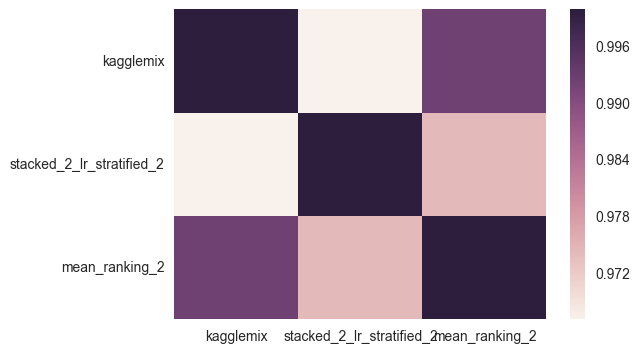

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
corr = mix[['kagglemix', 'stacked_2_lr_stratified_2', 'mean_ranking_2']].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [89]:
models_use = ['kagglemix', 'stacked_2_lr_stratified_2', 'mean_ranking_2']
               
mean_ranks_test = (mix[models_use].rank() / mix.shape[0]).mean(axis=1)

sub = pd.DataFrame()
sub['id'] = mix.id
sub['target'] = mean_ranks_test.values
sub.to_csv('kagglemix_and_my_submissions_2.csv', index=False)

# Final merge with other submissions

In [5]:
stacked_1 = pd.read_csv('stacked_1.csv')
xgb_submit = pd.read_csv('xgb_submit.csv')
rgf_submit = pd.read_csv('rgf_submit.csv')
Froza_and_Pascal = pd.read_csv('Froza_and_Pascal.csv')
gpari = pd.read_csv('gpari.csv')
mean_weighted_ranking_3 = pd.read_csv('mean_weighted_ranking_3.csv')
mean_ranking_3 = pd.read_csv('mean_ranking_3.csv')

merge = pd.DataFrame()
merge['id'] = stacked_1['id']

merge['stacked_1'] = stacked_1['target']
merge['xgb_submit'] = xgb_submit['target']
merge['rgf_submit'] = rgf_submit['target']
merge['Froza_and_Pascal'] = Froza_and_Pascal['target']
merge['gpari'] = gpari['target']
merge['mean_weighted_ranking_3'] = mean_weighted_ranking_3['target']
merge['mean_ranking_3'] = mean_weighted_ranking_3['target']



In [6]:
merge.head()

,id,stacked_1,xgb_submit,rgf_submit,Froza_and_Pascal,gpari,mean_weighted_ranking_3,mean_ranking_3
0,0,0.030060,0.039368,0.023685,0.025818,0.397413,0.300297,0.300297
1,1,0.028414,0.039615,0.024046,0.023008,0.391664,0.253740,0.253740
2,2,0.027665,0.037616,0.017658,0.022168,0.378311,0.222933,0.222933
3,3,0.023948,0.022206,0.014766,0.014779,0.257092,0.038314,0.038314
4,4,0.033980,0.054306,0.034534,0.032938,0.483567,0.628018,0.628018


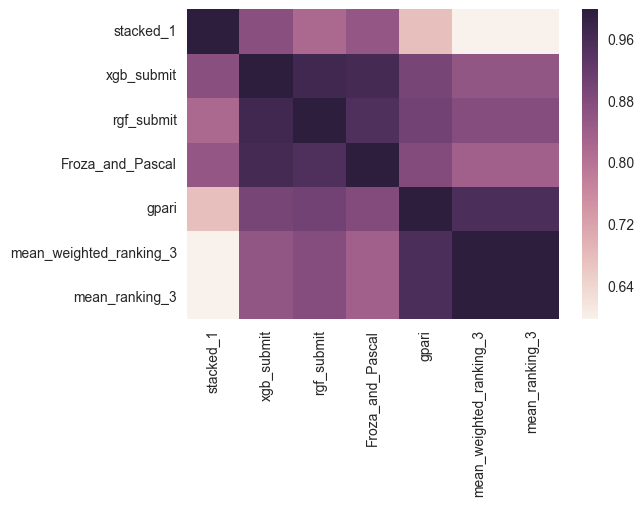

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
corr = merge.drop('id', axis=1).corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [169]:
               
mean_ranks_test = (merge.drop('id', axis=1).rank() / merge.shape[0]).mean(axis=1)

sub = pd.DataFrame()
sub['id'] = merge.id
sub['target'] = mean_ranks_test.values
sub.to_csv('kagglemix_and_my_submissions_3.csv', index=False)

# Final merge

In [8]:
train_meta.head()

,id,target,xgb1_FS1,xgb2_FS1,lgb1_FS3,lgb2_FS3,catboost1_FS3,catboost2_FS3,catboost3_FS3,RForest1_FS6,...,lgb2_FS15,catboost1_FS15,catboost2_FS15,catboost3_FS15,RForest1_FS16,RForest2_FS14,RForest3_FS14,LR1_FS14,xgb3_FS17,lgb3_FS17
0,7,0,0.053054,0.036508,0.035964,0.035512,0.038288,0.037519,0.038638,0.043202,...,0.037126,0.037185,0.035144,0.033398,0.044162,0.042106,0.039044,0.500689,0.061662,0.044947
1,9,0,0.052980,0.034036,0.035894,0.030180,0.033580,0.032459,0.030049,0.034117,...,0.031206,0.034490,0.033355,0.029478,0.036368,0.036774,0.038263,0.505967,0.043654,0.032765
2,13,0,0.031771,0.021110,0.016545,0.017060,0.017867,0.020013,0.017954,0.020899,...,0.018541,0.020107,0.019473,0.020568,0.021736,0.020704,0.021562,0.357723,0.035742,0.017009
3,16,0,0.021677,0.014408,0.014192,0.015797,0.014040,0.016284,0.015753,0.016483,...,0.015126,0.014184,0.015889,0.016059,0.017064,0.016857,0.017025,0.265479,0.023759,0.013855
4,17,0,0.055609,0.032151,0.030553,0.031474,0.029792,0.033922,0.034713,0.042312,...,0.031915,0.029748,0.034625,0.033698,0.046960,0.045260,0.043385,0.513518,0.051076,0.031679


In [9]:
merge.head()

,id,stacked_1,xgb_submit,rgf_submit,Froza_and_Pascal,gpari,mean_weighted_ranking_3,mean_ranking_3
0,0,0.030060,0.039368,0.023685,0.025818,0.397413,0.300297,0.300297
1,1,0.028414,0.039615,0.024046,0.023008,0.391664,0.253740,0.253740
2,2,0.027665,0.037616,0.017658,0.022168,0.378311,0.222933,0.222933
3,3,0.023948,0.022206,0.014766,0.014779,0.257092,0.038314,0.038314
4,4,0.033980,0.054306,0.034534,0.032938,0.483567,0.628018,0.628018


In [10]:
  
merge['xgb1'] = test_meta['xgb1']
merge['xgb3_FS7'] = test_meta['xgb3_FS7']
merge['lgb1'] = test_meta['lgb1']
merge['lgb3_FS7'] = test_meta['lgb3_FS7']
merge['catboost1_FS3'] = test_meta['catboost1_FS3']
#merge['NN_EntityEmbed'] = test_meta['NN_EntityEmbed']

In [12]:
merge.drop(['mean_weighted_ranking_3', 'mean_ranking_3'], axis=1, inplace=True)

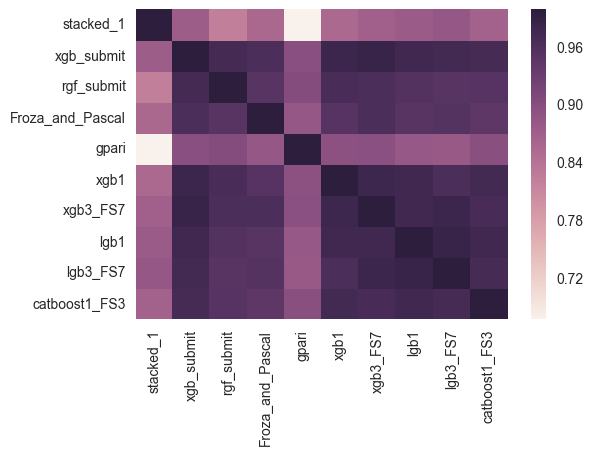

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
corr = merge.drop('id', axis=1).corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [14]:
               
mean_ranks_test = (merge[['stacked_1', 'xgb_submit', 'rgf_submit', 'Froza_and_Pascal',
       'gpari', 'xgb1', 'xgb3_FS7', 'lgb1', 'lgb3_FS7', 'catboost1_FS3',
       ]].rank() / merge.shape[0]).mean(axis=1)

sub = pd.DataFrame()
sub['id'] = merge.id
sub['target'] = mean_ranks_test.values
sub.to_csv('final_4.csv', index=False)

In [15]:
sub.head(50)

,id,target
0,0,0.306016
1,1,0.271509
2,2,0.218874
3,3,0.040812
4,4,0.600552
5,5,0.758882
6,6,0.070990
7,8,0.497112
8,10,0.827765
9,11,0.874879
